***A body of black***

***that carried no reflection***

***defying its own room***

***un-earthly eggs of decreation***

*(In Flames)*

---
# Analysis of potentially hazardous asteroids' orbital parameters
Using data on already discovered asteroid's we'll try to analyse orbital parameters of near-Earth asteroids and  find out familes of orbits with high probability of yet undiscovered potentially hazardous asteroids existance.

In [1]:
import pickle
from copy import copy, deepcopy
import numpy as np
import pandas as pd
import scipy.stats as ss
from sklearn import neighbors, svm
import matplotlib as mpl

# Import Asterion modules
import read_database as rdb
import generate_orbits as go
import learn_data as ld
import visualize_data as vd
import asterion_learn as al

# Plotting settings
%matplotlib inline
# font = {'size': 32}
# font = {'size': 25}
font = {'size': 14}
mpl.rc('font', **font)

---
## Asteroid database

**Load asteroid database:**

In [2]:
# columns = ['a', 'e', 'i', 'w', 'om', 'q', 'H', 'neo', 
#                'pha', 'moid', 'per', 'n', 'ma', 'epoch']

columns = ['a', 'e', 'i', 'w', 'om', 'q', 'H', 'neo', 'pha', 'moid']
database = rdb.load_database(columns, jobtime=True)
database.head(n=5)

Loading asteroid database...
Asteroid database loaded in 6.207178 seconds.


neo pha     H         e         a         q          i          om  \
0   N   N  3.34  0.075705  2.768134  2.558572  10.591705   80.314273   
1   N   N  4.13  0.230835  2.772779  2.132725  34.841162  173.087844   
2   N   N  5.33  0.256601  2.668831  1.984005  12.990102  169.862997   
3   N   N  3.20  0.089067  2.361348  2.151031   7.140406  103.842512   
4   N   N  6.85  0.191552  2.574343  2.081222   5.367954  141.591962   

            w     moid  
0   72.814757  1.59307  
1  309.999215  1.23093  
2  248.236797  1.03424  
3  151.111635  1.13866  
4  358.878896  1.09307

---
## Extract NEAs

In [3]:
neas, num_neas = rdb.get_neas(database, columns)

** Exclude extremal NEAs **

In [4]:
print len(neas[neas.a > 4])
print len(neas[neas.i > 90])

12
2


In [5]:
neas = neas[neas.a < 4]
neas = neas[neas.i < 90]

** Extract close-approaching NEAs **

In [6]:
neas_close = neas[neas.q <= 1.08]

**Extract groups of NEAs**

In [7]:
# apollos, num_apollos = rdb.get_apollos(neas)
# atens, num_atens = rdb.get_atens(neas)
# amors, num_amors = rdb.get_amors(neas)

# print "num_neas:", num_neas
# print "apollos:", num_apollos, "ratio:", num_apollos/float(num_neas)
# print "atens:", num_atens, "ratio:", num_atens/float(num_neas)
# print "amors:", num_amors, "ratio:", num_amors/float(num_neas)

**Extract PHAs and NHAs**

In [8]:
haz_real, nohaz_real = rdb.get_hazMOID(neas_close)
print "Number of real PHAs", len(haz_real)
print "Number of real NHAs:", len(nohaz_real)

Number of real PHAs 6606
Number of real NHAs: 4476


In [9]:
# vd.display_allparams([neas_close, neas_close], vd.combs, vd.colnames)

** Plot orbital distributions of rel PHAs and NHAs in the *w*-*q* plane **

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


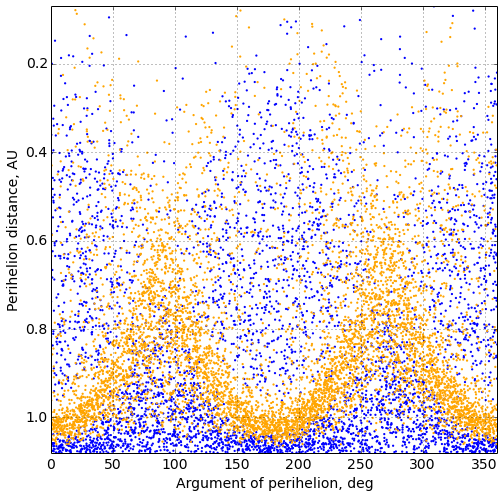

In [10]:
cutcol=['w', 'q']
vd.plot_distribution2d(cutcol, haz=haz_real, nohaz=nohaz_real, invertaxes=[0,1], labels=True)

---
## Generate virtual asteroids

**Specify a full subset of orbital parameters **

In [11]:
names = ['a', 'i', 'w', 'om', 'q']
full_names = [vd.colnames[nm] for nm in names]
data_subset = neas_close[names]

### Fit distributions of asteroids' orbital parameters with continuous distributions

Data cdf(xmax): 1.000000 	rayleigh_cdf(xmax): 0.999225
Data cdf(xmax): 1.000000 	lognorm_cdf(xmax): 0.982480
Data cdf(xmax): 1.000000 	uniform_cdf(xmax): 1.000000
Data cdf(xmax): 1.000000 	harmonic_cdf(xmax): 0.999970
Data cdf(xmax): 1.000000 	johnsonsu_cdf(xmax): 0.923356


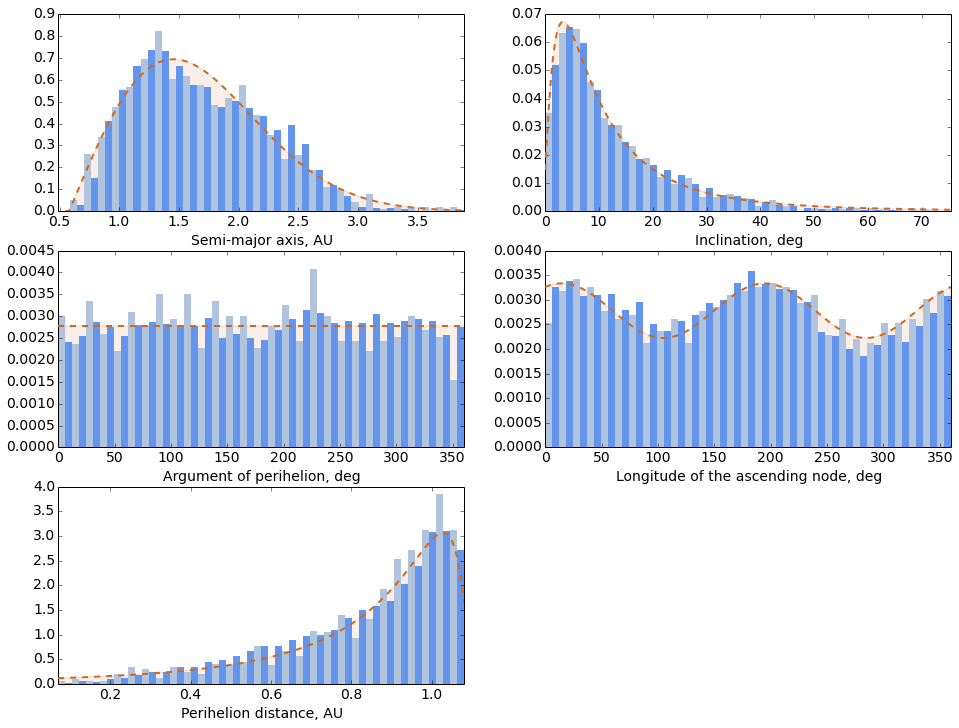

In [12]:
statdists = [ss.rayleigh, ss.lognorm, ss.uniform, go.HarmonicDistribution(), ss.johnsonsu]
distlist = go.get_param_distributions(data_subset, names, statdists, n=30, verbose=True)
go.plot_param_distributions(distlist, full_names, figsize=(16, 12))

### Generate random asteroids on the basis of the fitted continuous distributions

In [13]:
rnum_str = '2e5'
rnum = int(float(rnum_str))
distdict = {name:dist for name, dist in zip(names, distlist)}
randdata = go.gen_orbits(distdict, num=rnum)

** Check generated dataset to contain only asteroids with elliptical orbits **

In [14]:
e_rand = randdata['e']
print "Total number of generated asteroids:", len(randdata)
print "Number of failed asteroids:", len(e_rand[e_rand < 0])
print "Number of asteroids with hyperbolic orbits:", len(e_rand[e_rand > 1])

Total number of generated asteroids: 200000
Number of failed asteroids: 0
Number of asteroids with hyperbolic orbits: 0


**Calculate MOID for generated virtual asteroids or load previously computed results**

In [15]:
haz_dump = './asteroid_data/neas_haz_gen_%s.p' % rnum_str
nohaz_dump = './asteroid_data/neas_nohaz_gen_%s.p' % rnum_str
try:
    haz_gen = rdb.loadObject(haz_dump)
    nohaz_gen = rdb.loadObject(nohaz_dump)
except:
    rdb.calc_moid(randdata, jobtime=True)
    haz_gen, nohaz_gen = rdb.get_hazMOID(randdata)
    
    rdb.dumpObject(haz_gen, haz_dump)
    rdb.dumpObject(nohaz_gen, nohaz_dump)

In [16]:
print "Number of generated non-uniform PHAs", len(haz_gen)
print "Number of generated non-uniform NHAs:", len(nohaz_gen)

Number of generated non-uniform PHAs 97817
Number of generated non-uniform NHAs: 102183


**Generate additional set of uniformly distributed virtual asteroids **

In [17]:
names = ['a', 'i', 'w', 'om', 'q']
data_subset = neas_close[names]
unum_str = '3e4'
unum = int(float(unum_str))
statdists_u = [ss.uniform]*len(names)

distlist_u = go.get_param_distributions(data_subset, names, statdists_u, n=30, verbose=True)
distdict_u = {name:dist for name, dist in zip(names, distlist_u)}
randdata_u = go.gen_orbits(distdict_u, num=unum)

Data cdf(xmax): 1.000000 	uniform_cdf(xmax): 1.000000
Data cdf(xmax): 1.000000 	uniform_cdf(xmax): 1.000000
Data cdf(xmax): 1.000000 	uniform_cdf(xmax): 1.000000
Data cdf(xmax): 1.000000 	uniform_cdf(xmax): 1.000000
Data cdf(xmax): 1.000000 	uniform_cdf(xmax): 1.000000


** Check generated dataset to contain only asteroids with elliptical orbits **

In [18]:
e_randu = randdata_u['e']
print "Total number of generated uniform asteroids:", len(randdata_u)
print "Number of failed asteroids:", len(e_randu[e_randu < 0])
print "Number of asteroids with hyperbolic orbits:", len(e_randu[e_randu > 1])

Total number of generated uniform asteroids: 30000
Number of failed asteroids: 0
Number of asteroids with hyperbolic orbits: 0


**Calculate MOID for uniformly distributed virtual asteroids or load previously computed results**

In [19]:
haz_dump = './asteroid_data/neas_haz_genu_%s.p' % unum_str
nohaz_dump = './asteroid_data/neas_nohaz_genu_%s.p' % unum_str
try:
    haz_genu = rdb.loadObject(haz_dump)
    nohaz_genu = rdb.loadObject(nohaz_dump)
except:
    rdb.calc_moid(randdata_u, jobtime=True)
    haz_genu, nohaz_genu = rdb.get_hazMOID(randdata_u)

    rdb.dumpObject(haz_genu, haz_dump)
    rdb.dumpObject(nohaz_genu, nohaz_dump)

In [20]:
print "Number of generated uniform PHAs", len(haz_genu)
print "Number of generated uniform NHAs:", len(nohaz_genu)

Number of generated uniform PHAs 7173
Number of generated uniform NHAs: 22827


---
## Analyze virtual asteroids' orbital parameters

In [21]:
datasets_real = [haz_real, nohaz_real]
datasets_gen = [haz_gen, nohaz_gen]
datasets_genu = [haz_genu, nohaz_genu]

** Investigate NEA distributions for pairs of orbital parameters **

In [22]:
# vd.plot_alldistcombs(haz_real, nohaz_real)

** Plot distributions in a *w*-*q* plane for the non-uniform generated virtual asteroids **

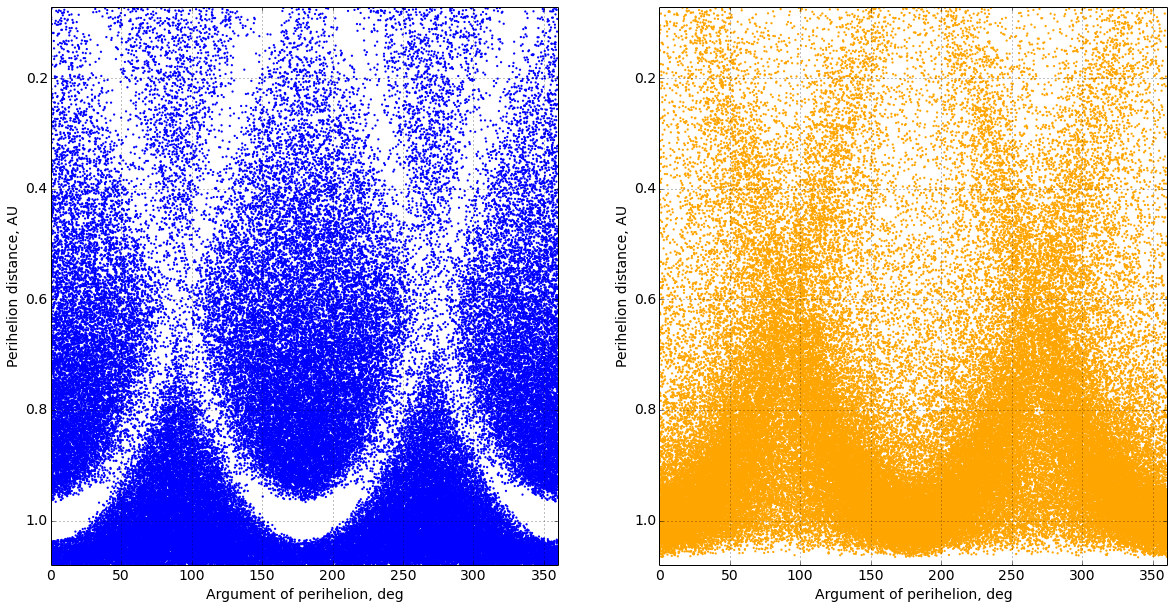

In [23]:
cols = ['w', 'q']
vd.plot_distributions2d(cols, haz_gen, nohaz_gen, labels=True, invertaxes=[0,1])

** Plot distributions in a *w*-*q* plane for the uniform generated virtual asteroids **

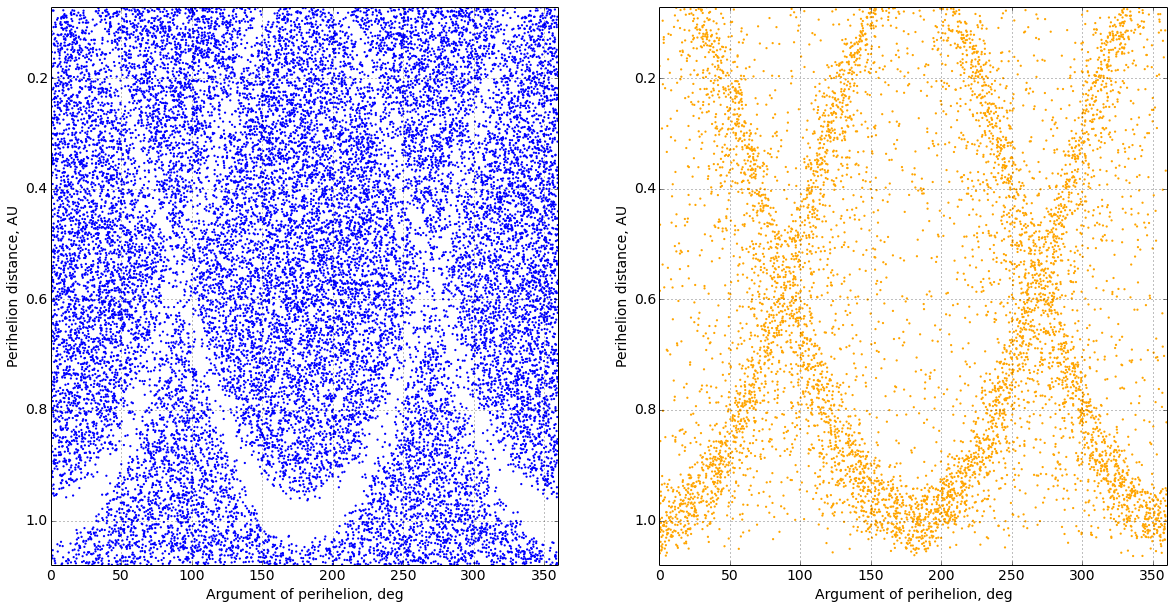

In [24]:
vd.plot_distributions2d(cols, haz_genu, nohaz_genu, labels=True, invertaxes=[0,1])

---
## Extract several clusters of NEAs

** Amplify uniform datasets by their symmetric copies over the vertical planes crossing *w=90* and *w=180* **

In [25]:
haz_genu = ld.add_doublemirror_column(haz_genu, 'w', 180)
nohaz_genu = ld.add_doublemirror_column(nohaz_genu, 'w', 180)

In [26]:
# haz_gen_mir = ld.add_doublemirror_column(haz_gen, 'w', 180)
# nohaz_gen_mir = ld.add_doublemirror_column(nohaz_gen, 'w', 180)

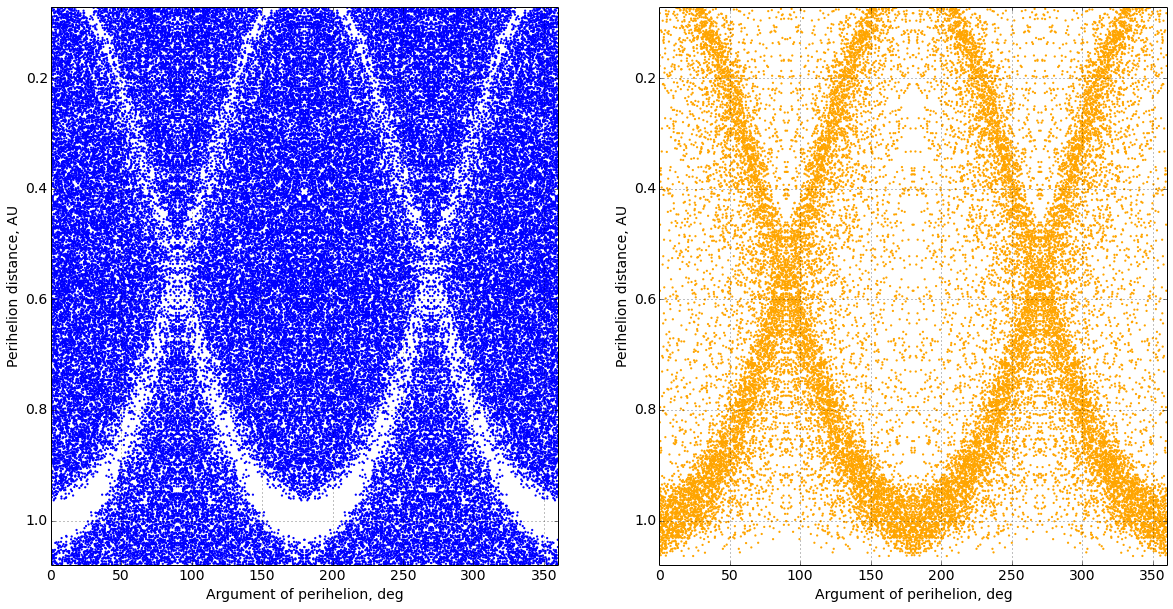

In [27]:
vd.plot_distributions2d(cols, haz_genu, nohaz_genu, labels=True, invertaxes=[0,1])

** Cut *w* and *q* columns from the datasets **

In [28]:
haz_real_cut, nohaz_real_cut = ld.cut_params(haz_real, nohaz_real, cols)
haz_gen_cut, nohaz_gen_cut = ld.cut_params(haz_gen, nohaz_gen, cols)
haz_genu_cut, nohaz_genu_cut = ld.cut_params(haz_genu, nohaz_genu, cols)
# haz_gen_mir_cut, nohaz_gen_mir_cut = ld.cut_params(haz_gen_mir, nohaz_gen_mir, cols)

**Normalize datasets**

In [29]:
bounds = ld.common_bounds([haz_real_cut, nohaz_real_cut, 
                           haz_gen_cut, nohaz_gen_cut,
                           haz_genu_cut, nohaz_genu_cut])

haz_real_cut, haz_real_sc = ld.normalize_dataset(haz_real_cut, bounds=bounds)
nohaz_real_cut, nohaz_real_sc = ld.normalize_dataset(nohaz_real_cut, bounds=bounds)

haz_gen_cut, haz_gen_sc = ld.normalize_dataset(haz_gen_cut, bounds=bounds)
nohaz_gen_cut, nohaz_gen_sc = ld.normalize_dataset(nohaz_gen_cut, bounds=bounds)

haz_genu_cut, haz_genu_sc = ld.normalize_dataset(haz_genu_cut, bounds=bounds)
nohaz_genu_cut, nohaz_genu_sc = ld.normalize_dataset(nohaz_genu_cut, bounds=bounds)

# haz_gen_mir_cut, haz_gen_mir_sc = ld.normalize_dataset(haz_gen_mir_cut, bounds=bounds)
# nohaz_gen_mir_cut, nohaz_gen_mir_sc = ld.normalize_dataset(nohaz_gen_mir_cut, bounds=bounds)

** Get common scales for each column in the datasets **

In [30]:
scale_sets = [haz_gen_sc, nohaz_gen_sc, 
              haz_genu_sc, nohaz_genu_sc, 
              haz_real_sc, nohaz_real_sc] 

scales = ld.common_scales(scale_sets)

** Find NEA clusters from the uniform dataset of NHAs **

In [31]:
# DBSCAN parameters
eps = [0.022]
min_samples = [105]
dens_layers = zip(eps, min_samples)

extracted_clusters = al.extract_dbclusters(nohaz_genu_cut, dens_layers)

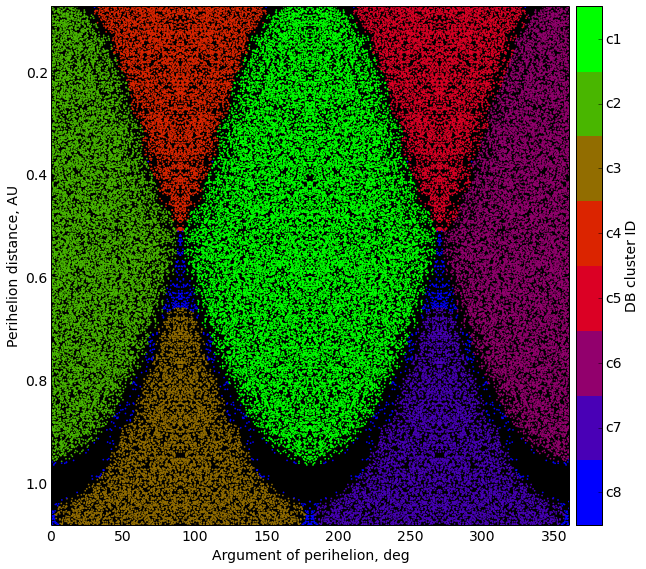

In [32]:
vd.plot_densclusters(extracted_clusters, labels=cols, cmap='brg', 
                     scales=scales, invertaxes=[0, 1], figsize=(9,8))

** Merge symmetric clusters**

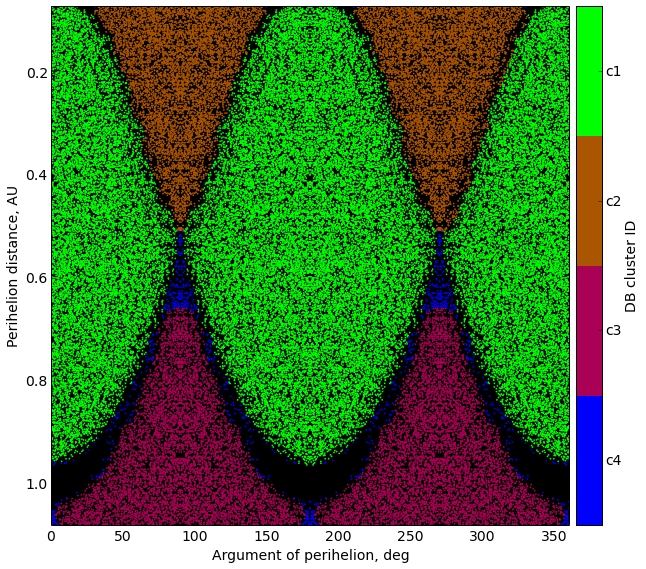

In [33]:
merged_clusters = al.merge_dbclusters(extracted_clusters, [[1,2,6], [4,5], [3,7]], merge_rest=False)
vd.plot_densclusters(merged_clusters, scales=scales, labels=cols, cmap='brg', invertaxes=[0, 1], figsize=(9,8))

### Transform clusters

In [34]:
c1, c2, c3, c4 = merged_clusters

** Split last cluster by the middle value of 'q' parameter**

In [35]:
qsplit = 0.46
c4_q = c4[:,1]
c41 = c4[np.where(c4_q <= qsplit)]
c42 = c4[np.where(c4_q > qsplit)]

** Merge clusters **

In [36]:
c1_ = np.concatenate((c3, c42))
c2_ = deepcopy(c1)
c3_ = np.concatenate((c2, c41))

** Set IDs for transformed clusters **

In [37]:
c1_[:,2], c2_[:,2], c3_[:,2] = 1.0, 2.0, 3.0

** Build new set of clusters **

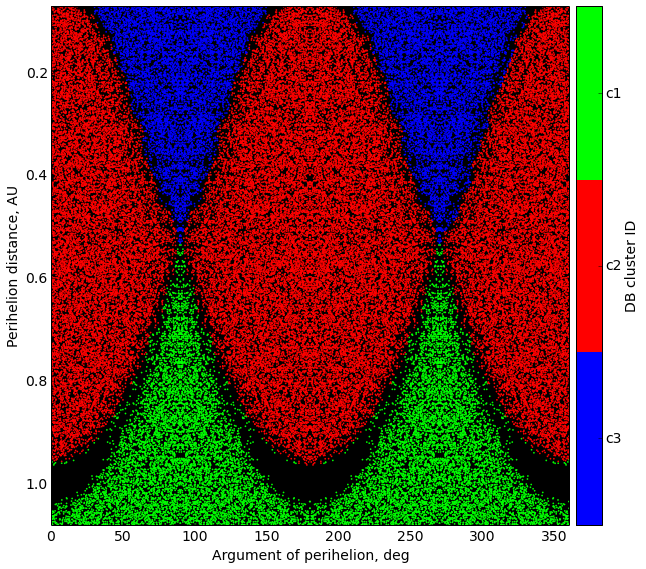

In [38]:
split_clusters = [c1_, c2_, c3_]
vd.plot_densclusters(split_clusters, scales=scales, labels=cols, cmap='brg', invertaxes=[0, 1], figsize=(9,8))

**Extract 'XX' cluster from the dataset of generated uniform PHAs **

In [39]:
eps = [0.028]
min_samples = [80]
dens_layers = zip(eps, min_samples)
extracted_clusters_X = al.extract_dbclusters(haz_genu_cut, dens_layers)

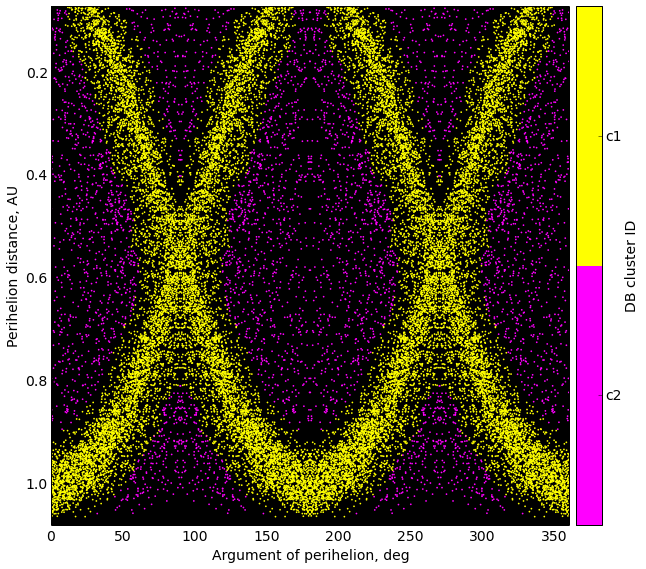

In [40]:
vd.plot_densclusters(extracted_clusters_X, scales=scales, labels=cols, cmap='spring', 
                     invertaxes=[0, 1], figsize=(9,8))

** Edit IDs of the asteroids in the PHA belt and add them to the cluster set**

In [41]:
c5, c6 = extracted_clusters_X
c5[:,2] = 4.0
split_clusters.append(c5)

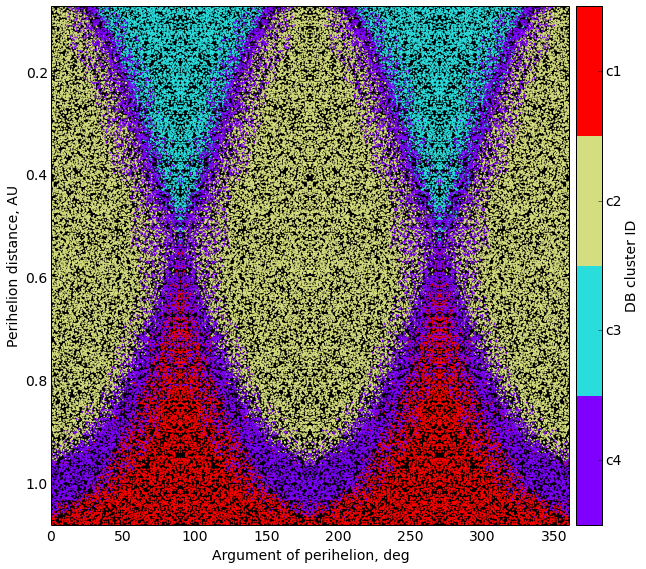

In [42]:
vd.plot_densclusters(split_clusters, scales=scales, labels=cols, cmap='rainbow', 
                     invertaxes=[0, 1], figsize=(9,8))

---
## Outline domains of NEAs using SVM

In [43]:
clf = svm.SVC(gamma=6., C=1000)
xtrain, clf, haz_prob = al.classify_dbclusters(split_clusters, clf, haz_real_cut, nohaz_real_cut)

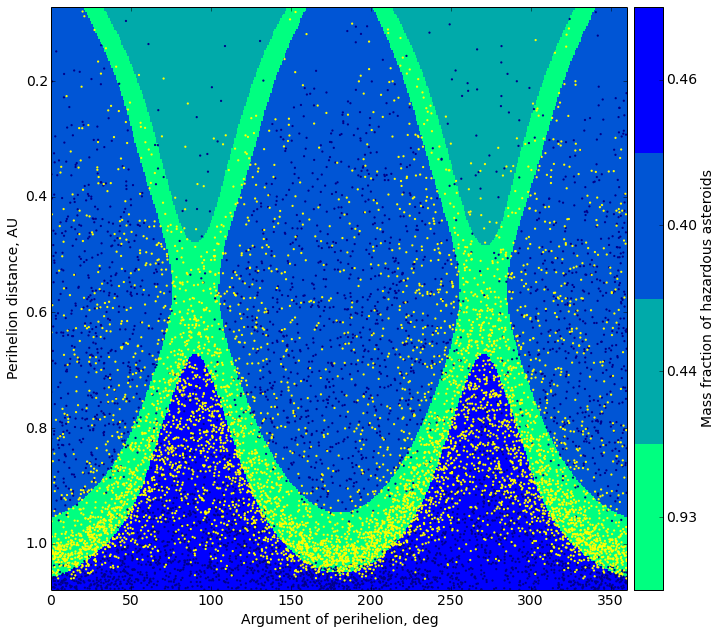

In [45]:
vd.plot_clf2d(clf, cols, num=400, haz_cut=haz_real_cut, nohaz_cut=nohaz_real_cut, figsize=(10,9),
              clustprobs=haz_prob[1:], invertaxes=[0, 1], scales=scales, cmap='winter')

** Classify asteroid datasets by cluster IDs **

In [ ]:
haz_real_clf = clf.predict(haz_real_cut)
nohaz_real_clf = clf.predict(nohaz_real_cut)

In [ ]:
haz_gen_clf = clf.predict(haz_gen_cut)
nohaz_gen_clf = clf.predict(nohaz_gen_cut)

In [ ]:
haz_genu_clf = clf.predict(haz_genu_cut)
nohaz_genu_clf = clf.predict(nohaz_genu_cut)

---
## Export domains of real and virtual NEAs as separate datasets

In [ ]:
dirpath = './asteroid_data/'      
domain_ids = range(1, len(split_clusters) + 1)

In [ ]:
def export_subgroups(db_suffix, datasets, datasets_clf):
    
    haz_nmb = dirpath + 'haz_' + db_suffix +'_dom%d.p'
    nohaz_nmb = dirpath + 'nohaz_' + db_suffix + '_dom%d.p'
    haz_db, nohaz_db = datasets
    haz_clf, nohaz_clf = datasets_clf

    for i in domain_ids:
        haz_inds = np.where(haz_clf == i)[0]
        nohaz_inds = np.where(nohaz_clf == i)[0]
        haz_rest_inds = np.where(haz_clf != i)[0]
        nohaz_rest_inds = np.where(nohaz_clf != i)[0]
        
        haz_gen_dom = haz_db.iloc[haz_inds]
        nohaz_gen_dom = nohaz_db.iloc[nohaz_inds]
        haz_gen_rest = haz_db.iloc[haz_rest_inds]
        nohaz_gen_rest = nohaz_db.iloc[nohaz_rest_inds]
        
        haz_name = haz_nmb %i
        nohaz_name = nohaz_nmb %i
        haz_name_rest = haz_name[:-2] + '_rest.p'
        nohaz_name_rest = nohaz_name[:-2] + '_rest.p'
        
        rdb.dumpObject(haz_gen_dom, haz_name)
        rdb.dumpObject(nohaz_gen_dom, nohaz_name)
        rdb.dumpObject(haz_gen_rest, haz_name_rest)
        rdb.dumpObject(nohaz_gen_rest, nohaz_name_rest)

In [ ]:
export_subgroups('real', [haz_real, nohaz_real], [haz_real_clf, nohaz_real_clf])
export_subgroups('gen', [haz_gen, nohaz_gen], [haz_gen_clf, nohaz_gen_clf])
export_subgroups('genu', [haz_genu, nohaz_genu], [haz_genu_clf, nohaz_genu_clf])